## Install all required library

In [1]:
%%capture
!pip install -r requirements.txt

## Import all required library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import warnings
import json
import os
from joblib import dump, load
from category_encoders import TargetEncoder

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.feature_extraction import FeatureHasher

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

## Import all settings

In [3]:
RPT_PATH = 'data/DataSample.rpt'
INFERENCE_PIPELINE_PATH = 'inference_pipeline'

os.makedirs('data', exist_ok=True)
os.makedirs(INFERENCE_PIPELINE_PATH, exist_ok=True)
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

## Basic Data Analysis

1. Initial thought. Generally, to perform valuation on a car, we needs
    * Car Brand
    * Car Initial Price
    * Car Mileage (Odometer reading)
    * Age of Car - (Current year - year of manufacture)
    * Car Exterior & Interior Condition
    * Trim Level (BadgeDescription)
    * Accident History (Can get from VIN)
    * Market Demand

2. Basic Exploratory Data Analysis
    * There is 62192 data points, with 130 features (64 float64 dtype, 60 object dtype, 6 int64 dtype)
    * 130 features can be splited in 10 categories
    * There are 44 data points where NewPrice is less than Sold_Amount. This is reasonable, as some items were sold after only 1-2 years, while others are antiques.

3. Identify features to remove:
    * that are useless/redundant to predict the car price
        * MakeCode - redundant with **Make**
        * FamilyCode - redundant with **Model**
        * SeriesModelYear - redundant with **YearGroup** (with minor discrepancies)
        * Columns that are identifier and are useless for car price prediction - 'SequenceNum', 'DriveCode', 'VIN', 'ModelCode' & 'EngineNum' 
        * Columns that has exact 1 unique value - 'ImportFlag', 'NormalChargeMins', 'NormalChargeVoltage' & 'TopSpeedElectricEng' 
    * Result degenerate feedback loop - ('AvgWholesale', 'AvgRetail', 'GoodWholesale', 'GoodRetail', 'TradeMin', 'TradeMax', 'PrivateMax') - (just for analysis purpose, not for vechicle price prediction)
    * Result in data leakage in predicting sales price

4. Find out the features that 
    * Possible to add in to improve the prediction 
        * Car History like accident history, which can be obtained from VIN - but needs to pay
        * Appearance of the car (by image)
    * Require further preprocessing
        * Convert date information to year, month, day, day of week

5. Try ways to embed categorical columns into vectors: 
    * One-hot Encoder (Baseline)
    * Target Encoder
    * Features Hashing
    * Embedding using neural network? (not using it because it is too expensive to train neural network for each category)

6. ML Model Building and Training (No dealing with null and normalization needed for the following model)
    * XGBRegressor
    * CatBoostRegressor
    * HistGradientBoostingRegressor

7. Evaluate through slice-based evaluation on 'Make'

8. Perform analysis on which features is most important for each models
9. Build the inference pipeline 
10. Tidy the code and write proper documentation

### Brief features categorization
#### (1) Manufacturer & Model Information - Features related to brand, model, and series identification.

1. Make: Manufacturer (e.g., Holden, Toyota).
2. Model: Car model name (e.g., Commodore, RAV4).
3. MakeCode: Manufacturer code (e.g., HOLD for Holden) - **REDUNDANT (Make)**.
4. FamilyCode: Internal code for the vehicle family (e.g., COMMODO) **REDUNDANT (Model)**.
5. Series: Generation or variant (e.g., VE, VR, ACA33R).
6. SeriesModelYear: Model year of the series (e.g., MY12, MY88, Series IV, ...).
7. BadgeDescription: Trim level (e.g., Omega, Executive).
8. BadgeSecondaryDescription: Secondary trim details (often empty).
9. OptionCategory: Vehicle type (e.g., PASS for passenger, SUV, VAN, BUS).
10. VFactsClass: Market classification (e.g., Passenger, SUV).
11. VFactsSegment: Size category (e.g., Large, Medium).
12. VFactsPrice: Price range (e.g., <$70K).

#### (2) Vehicle Identification & Classification - Unique identifiers and general classification.
13. YearGroup: Model year (e.g., 2008).
14. MonthGroup: Month of production (e.g., 0 = unknown).
15. SequenceNum: Unique identifier for the car - **USELESS**.
16. Description: Detailed description of a car (e.g., "VE Omega Sedan...").
17. CurrentRelease: Is the model current? (F = False, T=True).
18. ImportFlag: Import status (L = locally made) - **USELSES (exactly 1 unique value)**.
19. LimitedEdition: Is it a limited edition? (F = False, T=True).
20. BodyStyleDescription: Body type (e.g., Sedan, Wagon).
21. BodyConfigDescription: Body configuration (empty) - (0.7-850).
22. WheelBaseConfig: Wheelbase type.
23. Roofline: Roof design.
24. ExtraIdentification: Additional identifiers (empty).
25. DriveDescription: Drivetrain (e.g., Rear Wheel Drive).
26. DriveCode: Drivetrain code (e.g., RWD) - **USELESS**.
27. ModelCode: Internal model code (e.g., ACA33R-ANMXKQ) - **USELESS**.
28. BuildCountryOriginDescription: Manufacturing country (e.g., Australia, Japan, Thailand, ...).
29. VIN: Vehicle Identification Number - **USELESS**.

#### (3) Technical Specifications - Engine, transmission, and mechanical details.
30. GearTypeDescription: Transmission type (e.g., Automatic, Manual, Sports Automatic, ...).
31. GearLocationDescription: Gear lever position (e.g., Floor, Dash,Column, ...).
32. GearNum: Number of gears (1-9).
33. DoorNum: Number of doors (2-5).
34. EngineSize: Engine displacement (cc) - (659-7300).
35. EngineDescription: Engine name (e.g., 3.6i, 13B, 800, ...).
36. Cylinders: Number of cylinders (2-12).
37. FuelTypeDescription: Fuel type (e.g., Petrol, Diesel, LPG only, ...).
38. InductionDescription: Aspiration type (e.g., Aspirated, Supercharged, ...).
39. CamDescription: Valve mechanism (e.g., DOHC with VVT, Pushrod, OHC with VVT, ...).
40. EngineTypeDescription: Engine type (e.g., Piston, Piston - Electric OR Rotary).
41. FuelDeliveryDescription: Fuel injection type (e.g., Multi-Point).
42. MethodOfDeliveryDescription: Fuel delivery method (e.g., Electronic, Electronic Sequantial, ...).
43. ValvesCylinder: Valves per cylinder (2-5).
44. EngineCycleDescription: Engine cycle (e.g., 4 Stroke).
45. EngineConfigurationDescription: Engine layout (e.g., V6).
46. EngineLocation: Engine placement (e.g., Front).
47. EngineNum: Engine serial number - **USELESS**
48. FrontTyreSize: Front tire dimensions (e.g., 225/60 R16).
49. RearTyreSize: Rear tire dimensions.
50. FrontRimDesc: Front rim size (e.g., 16x7.0).
51. RearRimDesc: Rear rim size.

#### (4) Dimensions & Weight - Physical measurements and weights.
52. WheelBase: Distance between axles (mm) - (2-4332).
53. Height: Vehicle height (mm).
54. Length: Vehicle length (mm).
55. Width: Vehicle width (mm).
56. KerbWeight: Weight with fluids (kg).
57. TareMass: Empty weight (kg).
58. PayLoad: Maximum load capacity (kg) - (260-2701).
59. SeatCapacity: Number of seats (2-15).
60. FuelCapacity: Fuel tank size (liters) - (32-180).

#### (5) Performance Metrics - Power, torque, and towing.
61. Power: Engine power (kW).
62. PowerRPMFrom: RPM range start for peak power.
63. PowerRPMTo: RPM range end for peak power.
64. Torque: Engine torque (Nm).
65. TorqueRPMFrom: RPM range start for peak torque.
66. TorqueRPMTo: RPM range end for peak torque.
67. Acceleration: 0-100 km/h time (empty here).
68. TowingBrakes: Towing capacity with brakes (kg).
69. TowingNoBrakes: Towing capacity without brakes (kg).
70. TopSpeedElectricEng: Top speed on electric power - **USELESS - exactly 1 unique value**.

#### (6) Fuel & Emissions - Efficiency and environmental impact.
71. RonRating: Fuel octane rating.
72. FuelUrban: Urban fuel consumption (L/100km).
73. FuelExtraurban: Highway fuel consumption (L/100km).
74. FuelCombined: Combined fuel consumption (L/100km).
75. CO2Combined: Combined CO2 emissions (g/km).
76. CO2Urban: Urban CO2 emissions.
77. CO2ExtraUrban: Highway CO2 emissions.
78. EmissionStandard: Compliance standard (empty here).
79. MaxEthanolBlend: Ethanol compatibility (empty here).
80. GreenhouseRating: Environmental rating (1–10).
81. AirpollutionRating: Air pollution score (1–10).
82. OverallGreenStarRating: Overall eco-rating (1–5).

#### (7) Safety & Compliance - Safety ratings and regulatory data.
83. AncapRating: Safety rating (e.g., 4/5).
84. GrossCombinationMass: Total allowable weight (kg) - (1450-9071).
85. GrossVehicleMass: Vehicle max weight (kg) - (970-5670).
86. IsPPlateApproved: Approved for probationary drivers (T/F).

#### (8) Sales & Pricing - Pricing, sales history, and market data.
87. AverageKM: Average odometer reading.
88. GoodKM: Low odometer threshold.
89. AvgWholesale: Average wholesale price **Cant use it, make result degenerate feedback loop**. 
90. AvgRetail: Average retail price **Cant use it, make result degenerate feedback loop**.
91. GoodWholesale: Wholesale price for low-KM cars **Cant use it, make result degenerate feedback loop**.
92. GoodRetail: Retail price for low-KM cars **Cant use it, make result degenerate feedback loop**.
93. TradeMin: Minimum trade-in value **Cant use it, make result degenerate feedback loop**.
94. TradeMax: Maximum trade-in value **Cant use it, make result degenerate feedback loop**.
95. PrivateMax: Maximum private sale price **Cant use it, make result degenerate feedback loop**.
96. NewPrice: Original new price **This features is very important!, cannot simply impute the nan**.
97. Colour: Vehicle color.
98. Branch: Sale location (e.g., Perth).
99. SaleCategory: Sale type (e.g., Auction).
100. Sold_Date: Date sold **Also very important features, convert it into year,month,day**.
101. Compliance_Date: Compliance plate date.
102. Age_Comp_Months: Age in months at compliance.
103. KM: Odometer reading at sale.
104. **Sold_Amount: Sale price.**

#### (9) Maintenance & Warranty - Service and warranty terms.
105. WarrantyCustAssist: Roadside assistance duration.
106. FreeScheduledService: Free services (empty here).
107. WarrantyYears: Warranty duration (years).
108. WarrantyKM: Warranty kilometers.
109. FirstServiceKM: First service odometer.
110. FirstServiceMonths: First service time.
111. RegServiceMonths: Regular service interval.

#### (10) Miscellaneous Attributes - Electric/hybrid specs and charging.
112. AltEngEngineType: Alternate engine type (e.g., electric).
113. AltEngBatteryType: Battery type.
114. AltEngCurrentType: Current type (AC/DC).
115. AltEngAmpHours: Battery capacity (Ah).
116. AltEngVolts: Battery voltage.
117. AltEngChargingMethod: Charging method.
118. AltEngPower: Electric motor power (kW).
119. AltEngPowerFrom: Power RPM range start.
120. AltEngPowerTo: Power RPM range end.
121. AltEngTorque: Electric motor torque (Nm).
122. AltEngTorqueFrom: Torque RPM range start.
123. AltEngTorqueTo: Torque RPM range end.
124. AltEngDrive: Electric drivetrain type.
125. NormalChargeMins: Standard charging time - **USELSES (exactly 1 unique value)**.
126. QuickChargeMins: Fast charging time.
127. NormalChargeVoltage: Standard charging voltage - **USELSES (exactly 1 unique value)**.
128. QuickChargeVoltage: Fast charging voltage.
129. KMRangeElectricEng: Electric range (km).
130. ElectricEngineLocation: Electric motor placement.

## Visualize some datapoints

In [4]:
# Read the file with tab delimiter
df = pd.read_csv(RPT_PATH, delimiter='\	', engine='python')

print("DataFrame shape (rows, columns):", df.shape)
df.head(3).T

DataFrame shape (rows, columns): (62192, 130)


,0,1,2
Make,Holden,Holden,Toyota
Model,Commodore,Commodore,RAV4
MakeCode,HOLD,HOLD,TOYO
FamilyCode,COMMODO,COMMODO,RAV4
YearGroup,2008,1993,2012
MonthGroup,0,7,0
SequenceNum,0,41,6
Description,VE Omega Sedan 4dr. Auto 4sp 3.6i,VR Executive Wagon 5dr. Auto 4sp 3.8i,ACA33R MY12 CV Wagon 5dr Man 5sp 4x4 2.4i
CurrentRelease,F,F,F
ImportFlag,L,L,L


## Identify features to remove

In [5]:
# Identify features with many missing values based on threshold (retain first as null value may be meaningful)
for threshold in range(50, 101, 1):
    threshold = threshold / 100
    high_missing_cols = [col for col in df.columns if df[col].isna().mean() > threshold]
    print(f"Columns with >{threshold*100:.1f}% missing values ({len(high_missing_cols)}):", high_missing_cols)

Columns with >50.0% missing values (36): ['SeriesModelYear', 'BadgeSecondaryDescription', 'BodyConfigDescription', 'WheelBaseConfig', 'Roofline', 'ExtraIdentification', 'GrossCombinationMAss', 'PowerRPMFrom', 'TorqueRPMFrom', 'Acceleration', 'WarrantyCustAssist', 'FreeScheduledService', 'AltEngEngineType', 'AltEngBatteryType', 'AltEngCurrentType', 'AltEngAmpHours', 'AltEngVolts', 'AltEngChargingMethod', 'AltEngPower', 'AltEngPowerFrom', 'AltEngPowerTo', 'AltEngTorque', 'AltEngTorqueFrom', 'AltEngTorqueTo', 'AltEngDrive', 'NormalChargeMins', 'QuickChargeMins', 'NormalChargeVoltage', 'QuickChargeVoltage', 'KMRangeElectricEng', 'ElectricEngineLocation', 'TopSpeedElectricEng', 'CO2Urban', 'CO2ExtraUrban', 'EmissionStandard', 'MaxEthanolBlend']
Columns with >51.0% missing values (36): ['SeriesModelYear', 'BadgeSecondaryDescription', 'BodyConfigDescription', 'WheelBaseConfig', 'Roofline', 'ExtraIdentification', 'GrossCombinationMAss', 'PowerRPMFrom', 'TorqueRPMFrom', 'Acceleration', 'Warrant

In [6]:
# Get columns with exactly 1 or full unique value
single_unique_cols = [col for col in df.columns if df[col].nunique() == 1]
fully_unique_cols = [col for col in df.columns if df[col].nunique() == len(df)]

print("Columns with exactly 1 unique value:", single_unique_cols)
print("Columns with full unique value:", fully_unique_cols)

Columns with exactly 1 unique value: ['ImportFlag', 'NormalChargeMins', 'NormalChargeVoltage', 'TopSpeedElectricEng']
Columns with full unique value: []


In [7]:
USELESS_COLS = ['MakeCode', 'FamilyCode', 'DriveCode', 
                'ModelCode', 'SequenceNum', 'VIN', 
                'EngineNum', 'SeriesModelYear']
IRRELEVANT_COLS = ['AvgWholesale', 'AvgRetail', 'GoodWholesale', 
                   'GoodRetail', 'TradeMin', 'TradeMax', 'PrivateMax']

COL_TO_REMOVE = USELESS_COLS + IRRELEVANT_COLS + single_unique_cols + fully_unique_cols

# Save the columns to remove into a file for future use (during inference)
with open('data/COL_TO_REMOVE.json', 'w') as file:
    json.dump(COL_TO_REMOVE, file)

df_dropped = df.drop(columns=COL_TO_REMOVE)
print("There is total of", len(COL_TO_REMOVE), "columns to remove")
print("Now, the shape of the dataframe is", df_dropped.shape) 

There is total of 19 columns to remove
Now, the shape of the dataframe is (62192, 111)


## Exploratory Data Analysis
* To find out some possible useful insights from the features   
* left it to be future works due to time constraints

## Data Preprocessing

### Drop some rows and process datetime data

In [8]:
# Drop rows with missing values in 'Sold_Amount'
print("Originally, the shape of the dataframe is", df_dropped.shape)
df_cleaned = df_dropped.dropna(subset=['Sold_Amount'])
print("After removing rows with missing values in 'Sold_Amount', the shape of the dataframe is", df_cleaned.shape)

Originally, the shape of the dataframe is (62192, 111)
After removing rows with missing values in 'Sold_Amount', the shape of the dataframe is (62188, 111)


In [9]:
# Process data information into numerical value
if 'Sold_Date' in df_cleaned.columns:
    df_cleaned['Sold_Date'] = pd.to_datetime(df_cleaned['Sold_Date'], errors='coerce').copy()
    # Extract datetime features
    df_cleaned['Sold_Year'] = df_cleaned['Sold_Date'].dt.year
    df_cleaned['Sold_Month'] = df_cleaned['Sold_Date'].dt.month
    df_cleaned['Sold_Day'] = df_cleaned['Sold_Date'].dt.day
    df_cleaned['Sold_DayOfWeek'] = df_cleaned['Sold_Date'].dt.dayofweek
    # Drop original Sold_Date
    df_cleaned.drop('Sold_Date', axis=1, inplace=True)
print("After processing date information, the shape of dataframe is", df_cleaned.shape)

After processing date information, the shape of dataframe is (62188, 114)


In [10]:
# Identify categorical (object or category) and numerical columns
cat_cols = df_cleaned.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = df_cleaned.select_dtypes(include=['number']).columns.tolist()
num_cols.remove('Sold_Amount')

print(f"Categorical columns ({len(cat_cols)}):", cat_cols)
print(f"Numerical columns ({len(num_cols)}):", num_cols)


Categorical columns (50): ['Make', 'Model', 'Description', 'CurrentRelease', 'LimitedEdition', 'Series', 'BadgeDescription', 'BadgeSecondaryDescription', 'BodyStyleDescription', 'BodyConfigDescription', 'WheelBaseConfig', 'Roofline', 'ExtraIdentification', 'DriveDescription', 'GearTypeDescription', 'GearLocationDescription', 'EngineDescription', 'FuelTypeDescription', 'InductionDescription', 'OptionCategory', 'CamDescription', 'EngineTypeDescription', 'FuelDeliveryDescription', 'MethodOfDeliveryDescription', 'BuildCountryOriginDescription', 'EngineCycleDescription', 'EngineConfigurationDescription', 'EngineLocation', 'FrontTyreSize', 'RearTyreSize', 'FrontRimDesc', 'RearRimDesc', 'WarrantyCustAssist', 'FreeScheduledService', 'AltEngEngineType', 'AltEngBatteryType', 'AltEngCurrentType', 'AltEngChargingMethod', 'AltEngDrive', 'ElectricEngineLocation', 'EmissionStandard', 'MaxEthanolBlend', 'VFactsClass', 'VFactsSegment', 'VFactsPrice', 'IsPPlateApproved', 'Colour', 'Branch', 'SaleCategor

In [11]:
# Split the data into training (80%) and testing sets (20%)
X_train, X_test, y_train, y_test = train_test_split(
    df_cleaned.drop('Sold_Amount', axis=1),
    df_cleaned['Sold_Amount'],
    test_size=0.2,
    random_state=0,
)

### One-hot encoding method

In [12]:
### max_categories need to be set properly, too low will results loss of information, too high will results in too many columns
### If set to be 5, Total number of columns with unique values exceeding the maximum allowed: 31/50
### If set to be 10, Total number of columns with unique values exceeding the maximum allowed: 21/50 (Seem to be a good balance points)
### If set to be 15, Total number of columns with unique values exceeding the maximum allowed: 19/50
### If set to be 20, Total number of columns with unique values exceeding the maximum allowed: 17/50
for max_categories in [5,10,15,20]:
    count         = 0
    for col in cat_cols:
        unique_values = X_train[col].nunique()
        if unique_values > max_categories:
            count+=1
    print(f"Total number of columns with unique values exceeding the maximum allowed: {count}")

Total number of columns with unique values exceeding the maximum allowed: 31
Total number of columns with unique values exceeding the maximum allowed: 21
Total number of columns with unique values exceeding the maximum allowed: 19
Total number of columns with unique values exceeding the maximum allowed: 17


In [13]:
# Function to determine and map top categories in training data
## Get top categories in training data
def get_top_categories(df, cat_cols, max_categories=10, file_path='data/top_categories.json'):
    ### Save top_categories_dict to JSON file
    def save_top_categories(top_categories_dict, file_path='data/top_categories.json'):
        with open(file_path, 'w') as f:
            json.dump(top_categories_dict, f)

    ### Load top_categories_dict from JSON file
    def load_top_categories(file_path='data/top_categories.json'):
        with open(file_path, 'r') as f:
            return json.load(f)
        
    if os.path.exists(file_path):
        top_categories_dict = load_top_categories(file_path)
    else:
        top_categories_dict = {}
        for col in cat_cols:
            value_counts = df[col].value_counts()
            num_unique_values = len(value_counts)

            num_category_retain = max_categories - 1 if num_unique_values > max_categories else num_unique_values - 1
            top_categories = value_counts.head(num_category_retain).index.tolist()

            top_categories_dict[col] = top_categories
        save_top_categories(top_categories_dict, file_path) # Save the dictionary to JSON file
    return top_categories_dict

## Function to map categories using the provided top categories
def apply_top_categories(df, top_categories_dict):
    for col, top_categories in top_categories_dict.items():
        df[col] = df[col].fillna('Missing')  # Fix NaN
        df[col] = df[col].apply(lambda x: x if x in top_categories else 'Other')

    # Verify the changes
    for col in top_categories_dict.keys():
        if df[col].nunique() > len(top_categories_dict[col]) + 1:
            raise Exception(f"Column '{col}' has too many unique values after applying top categories.")
    return df

# Step 4: Fit OneHotEncoder on training data and transform both datasets
## Function to get OneHotEncoder ()
def get_one_hot_encoder(X_train=None, cat_cols=None):
    if os.path.exists('data/onehot_encoder.joblib'):
        encoder = load('data/onehot_encoder.joblib')
    elif X_train is None or cat_cols is None:
        raise ValueError("X_train and cat_cols must be provided if data/onehot_encoder.joblib does not exist")
    else:
        encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
        encoder.fit(X_train[cat_cols])
        dump(encoder, 'data/onehot_encoder.joblib')  # Save to file

    return encoder
    
def transform_one_hot_encoder(X_data, cat_cols):
    encoder = get_one_hot_encoder()
    X_data_encoded = pd.DataFrame(
        encoder.transform(X_data[cat_cols]),
        columns=encoder.get_feature_names_out(cat_cols),
        index=X_data.index
    )
    return X_data_encoded


# Step 5: Apply consistent handling 
max_categories = 10
top_categories_dict = get_top_categories(X_train, cat_cols, max_categories=max_categories)

X_train = apply_top_categories(X_train, top_categories_dict)
X_test = apply_top_categories(X_test, top_categories_dict)

# Step 6: One-hot encoding with consistent columns
# Transform train and test sets
encoder = get_one_hot_encoder(X_train, cat_cols)
X_train_OH_encoded = transform_one_hot_encoder(X_train, cat_cols)
X_test_OH_encoded = transform_one_hot_encoder(X_test, cat_cols)

# Combine with numerical columns
X_train_OH_encoded = pd.concat([X_train[num_cols], X_train_OH_encoded], axis=1)
X_test_OH_encoded  = pd.concat([X_test[num_cols], X_test_OH_encoded], axis=1)

# Preprocessing for XGBoost
X_train_OH_encoded.columns = [str(col).replace('[', '_').replace(']', '_').replace('<', '_') for col in X_train_OH_encoded.columns]
X_test_OH_encoded.columns = [str(col).replace('[', '_').replace(']', '_').replace('<', '_') for col in X_test_OH_encoded.columns]

# Now X_train_OH_encoded and X_test_OH_encoded have identical columns
print("Total number of columns in X_train_OH_encoded:", len(X_train_OH_encoded.columns))
print("Total number of columns in X_test_OH_encoded:", len(X_test_OH_encoded.columns))
print("Total number of X_test_OH_encoded.columns == X_train_OH_encoded.columns:", (X_test_OH_encoded.columns == X_train_OH_encoded.columns).sum())

Total number of columns in X_train_OH_encoded: 346
Total number of columns in X_test_OH_encoded: 346
Total number of X_test_OH_encoded.columns == X_train_OH_encoded.columns: 346


In [26]:
class OneHotInferencePipeline:
    def __init__(self, top_categories_path='data/top_categories.json', 
                 encoder_path='data/onehot_encoder.joblib',
                 num_cols=None, cat_cols=None):
        """
        Initialize the pipeline with pre-saved artifacts and column lists.
        
        Args:
            top_categories_path (str): Path to JSON file with top categories.
            encoder_path (str): Path to saved OneHotEncoder.
            num_cols (list): Numerical columns used during training.
            cat_cols (list): Categorical columns used during training.
        """
        # Load top categories mapping
        with open(top_categories_path, 'r') as f:
            self.top_categories_dict = json.load(f)
        
        # Load pre-fitted OneHotEncoder
        self.encoder = load(encoder_path)
        
        # Store column lists
        self.num_cols = num_cols
        self.cat_cols = cat_cols
        
        # Precompute expected feature names after sanitization
        # 1. Get original column order (numerical first, then one-hot encoded)
        original_features = self.num_cols + self.encoder.get_feature_names_out(self.cat_cols).tolist()
        # 2. Apply sanitization to match training
        self.feature_names = [self._sanitize(col) for col in original_features]

    def _sanitize(self, col_name):
        """Replicate the column name sanitization from training."""
        return str(col_name).replace('[', '_').replace(']', '_').replace('<', '_')

    def transform(self, raw_data):
        """
        Process raw data through top-category mapping, one-hot encoding, and feature alignment.
        
        Args:
            raw_data (pd.DataFrame): Raw input data with original columns.
            
        Returns:
            pd.DataFrame: Processed data ready for model prediction.
        """
        # Validate input structure
        if not isinstance(raw_data, pd.DataFrame):
            raw_data = pd.DataFrame(raw_data)
        
        # Drop the columns that are not needed
        with open('data/COL_TO_REMOVE.json', 'r') as file:
            COL_TO_REMOVE = json.load(file)
        raw_data = raw_data.drop(columns=COL_TO_REMOVE)

        # Process the date information
        if 'Sold_Date' in raw_data.columns:
            raw_data['Sold_Date'] = pd.to_datetime(raw_data['Sold_Date'], errors='coerce').copy()
            # Extract datetime features
            raw_data['Sold_Year'] = raw_data['Sold_Date'].dt.year
            raw_data['Sold_Month'] = raw_data['Sold_Date'].dt.month
            raw_data['Sold_Day'] = raw_data['Sold_Date'].dt.day
            raw_data['Sold_DayOfWeek'] = raw_data['Sold_Date'].dt.dayofweek
            # Drop original Sold_Date
            raw_data.drop('Sold_Date', axis=1, inplace=True)
            
        # Ensure required columns exist
        missing_cols = set(self.cat_cols + self.num_cols) - set(raw_data.columns)
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")

        processed = raw_data.copy()
        
        # Apply top-category mapping to categorical columns
        for col, allowed_values in self.top_categories_dict.items():
            # 1. Fill NaN with 'Missing'
            processed[col] = processed[col].fillna('Missing')
            # 2. Map non-top categories to 'Other'
            processed[col] = processed[col].apply(
                lambda x: x if x in allowed_values else 'Other'
            )
        
        # One-hot encode categorical features
        cat_encoded = pd.DataFrame(
            self.encoder.transform(processed[self.cat_cols]),
            columns=self.encoder.get_feature_names_out(self.cat_cols),
            index=processed.index
        )
        
        # Combine with numerical features
        combined = pd.concat([processed[self.num_cols], cat_encoded], axis=1)
        
        # Sanitize column names (critical for XGBoost compatibility)
        combined.columns = [self._sanitize(col) for col in combined.columns]
        
        # Enforce column order seen during training
        return combined.reindex(columns=self.feature_names)


pipeline = OneHotInferencePipeline(
    top_categories_path='data/top_categories.json',
    encoder_path='data/onehot_encoder.joblib',
    num_cols=num_cols,
    cat_cols=cat_cols
)
dump(pipeline, f'{INFERENCE_PIPELINE_PATH}/One_hot_encoding_InferencePipeline.pkl')

['inference_pipeline/One_hot_encoding_InferencePipeline.pkl']

### Target encoding method

In [15]:
# Initialize the encoder
target_encoder = TargetEncoder(cols=cat_cols, 
                               handle_missing='return_nan', 
                               handle_unknown='value')

# Fit on training data
target_encoder.fit(X_train[cat_cols], y_train)

# Transform both train and test
X_train_cat_encoded = target_encoder.transform(X_train[cat_cols])
X_test_cat_encoded = target_encoder.transform(X_test[cat_cols])

# Concatenate with numerical features
X_train_T_encoded = pd.concat([X_train_cat_encoded, X_train[num_cols]], axis=1)
X_test_T_encoded = pd.concat([X_test_cat_encoded, X_test[num_cols]], axis=1)

# Now X_train_OH_encoded and X_test_OH_encoded have identical columns
print("Shape in X_train_T_encoded:", X_train_T_encoded.shape)
print("Shape in X_test_OH_encoded:", X_test_T_encoded.shape)
print("Total number of X_test_T_encoded.columns == X_train_T_encoded.columns:", (X_test_T_encoded.columns == X_train_T_encoded.columns).sum())


Shape in X_train_T_encoded: (49750, 113)
Shape in X_test_OH_encoded: (12438, 113)
Total number of X_test_T_encoded.columns == X_train_T_encoded.columns: 113


In [16]:
class Target_encoding_InferencePipeline:
    def __init__(self, target_encoder, cat_cols, num_cols):
        """
        Initialize the inference pipeline with fitted components and column info.
        
        Args:
            target_encoder (TargetEncoder): Pre-fitted TargetEncoder.
            cat_cols (list): Categorical columns used during training.
            num_cols (list): Numerical columns used during training.
        """
        self.target_encoder = target_encoder
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        # Store the expected feature order (cat_cols followed by num_cols)
        self.feature_names = self.cat_cols + self.num_cols

    def transform(self, raw_data):
        """
        Process raw data by encoding categorical features and combining with numerical features.
        
        Args:
            raw_data (pd.DataFrame): Raw input data to process.
            
        Returns:
            pd.DataFrame: Processed data with encoded features.
        """
        # Ensure input is a DataFrame to handle column selection
        if not isinstance(raw_data, pd.DataFrame):
            raw_data = pd.DataFrame(raw_data)
        
        # Drop the columns that are not needed
        with open('data/COL_TO_REMOVE.json', 'r') as file:
            COL_TO_REMOVE = json.load(file)
        raw_data = raw_data.drop(columns=COL_TO_REMOVE)

        # Process the date information
        if 'Sold_Date' in raw_data.columns:
            raw_data['Sold_Date'] = pd.to_datetime(raw_data['Sold_Date'], errors='coerce').copy()
            # Extract datetime features
            raw_data['Sold_Year'] = raw_data['Sold_Date'].dt.year
            raw_data['Sold_Month'] = raw_data['Sold_Date'].dt.month
            raw_data['Sold_Day'] = raw_data['Sold_Date'].dt.day
            raw_data['Sold_DayOfWeek'] = raw_data['Sold_Date'].dt.dayofweek
            # Drop original Sold_Date
            raw_data.drop('Sold_Date', axis=1, inplace=True)

        # Extract and encode categorical columns
        raw_data_cat = raw_data[self.cat_cols]
        raw_data_cat_encoded = self.target_encoder.transform(raw_data_cat)
        
        # Extract numerical columns
        raw_data_num = raw_data[self.num_cols]
        
        # Concatenate encoded categoricals and numericals
        processed_data = pd.concat([raw_data_cat_encoded, raw_data_num], axis=1)
        
        # Ensure columns are in the correct order (matches training data)
        processed_data = processed_data.reindex(columns=self.feature_names)
        
        return processed_data
    
inference_pipeline = Target_encoding_InferencePipeline(
    target_encoder=target_encoder,
    cat_cols=cat_cols,
    num_cols=num_cols
)

dump(inference_pipeline, f'{INFERENCE_PIPELINE_PATH}/Target_encoding_InferencePipeline.pkl')

['inference_pipeline/Target_encoding_InferencePipeline.pkl']

### FeatureHasher

In [17]:
import pandas as pd

# Initialize the feature hasher
n_features = 100
hasher     = FeatureHasher(n_features=n_features,input_type='string')

# Apply the hasher to the categorical columns
X_train_cat_hashed = hasher.transform(X_train[cat_cols].astype(str).values)
X_test_cat_hashed = hasher.transform(X_test[cat_cols].astype(str).values)

# Convert the sparse matrix to a dense format (if needed) and create DataFrames
X_train_cat_hashed_df = pd.DataFrame(X_train_cat_hashed.toarray(), columns=[f'hashed_{i}' for i in range(n_features)])
X_test_cat_hashed_df = pd.DataFrame(X_test_cat_hashed.toarray(), columns=[f'hashed_{i}' for i in range(n_features)])

# Concatenate with numerical features
X_train_FH_encoded = pd.concat([X_train_cat_hashed_df, X_train[num_cols].reset_index(drop=True)], axis=1)
X_test_FH_encoded = pd.concat([X_test_cat_hashed_df, X_test[num_cols].reset_index(drop=True)], axis=1)

# Now X_train_OH_encoded and X_test_OH_encoded have identical columns
print("Shape in X_train_T_encoded:", X_train_FH_encoded.shape)
print("Shape in X_test_FH_encoded:", X_test_FH_encoded.shape)
print("Total number of X_test_FH_encoded.columns == X_train_FH_encoded.columns:", (X_test_FH_encoded.columns == X_train_FH_encoded.columns).sum())


Shape in X_train_T_encoded: (49750, 163)
Shape in X_test_FH_encoded: (12438, 163)
Total number of X_test_FH_encoded.columns == X_train_FH_encoded.columns: 163


In [18]:
class Feature_Hashing_InferencePipeline:
    def __init__(self, hasher, cat_cols, num_cols):
        """
        Initialize the pipeline with a configured FeatureHasher and column info.
        
        Args:
            hasher (FeatureHasher): Pre-configured FeatureHasher (with `n_features` and `input_type`).
            cat_cols (list): Categorical columns used during training.
            num_cols (list): Numerical columns used during training.
        """
        self.hasher = hasher
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        
        # Store expected output feature names (hashed columns followed by numerical columns)
        self.feature_names = (
            [f"hashed_{i}" for i in range(self.hasher.n_features)] 
            + self.num_cols
        )

    def transform(self, raw_data):
        """
        Process raw data by hashing categorical features and combining with numerical features.
        
        Args:
            raw_data (pd.DataFrame): Raw input data to process.
            
        Returns:
            pd.DataFrame: Processed data with hashed features and numerical columns.
        """
        # Ensure input is a DataFrame
        if not isinstance(raw_data, pd.DataFrame):
            raw_data = pd.DataFrame(raw_data)
        
        # Drop the columns that are not needed
        with open('data/COL_TO_REMOVE.json', 'r') as file:
            COL_TO_REMOVE = json.load(file)
        raw_data = raw_data.drop(columns=COL_TO_REMOVE)

        # Process the date information
        if 'Sold_Date' in raw_data.columns:
            raw_data['Sold_Date'] = pd.to_datetime(raw_data['Sold_Date'], errors='coerce').copy()
            # Extract datetime features
            raw_data['Sold_Year'] = raw_data['Sold_Date'].dt.year
            raw_data['Sold_Month'] = raw_data['Sold_Date'].dt.month
            raw_data['Sold_Day'] = raw_data['Sold_Date'].dt.day
            raw_data['Sold_DayOfWeek'] = raw_data['Sold_Date'].dt.dayofweek
            # Drop original Sold_Date
            raw_data.drop('Sold_Date', axis=1, inplace=True)

        # Process categorical columns
        raw_data_cat = raw_data[self.cat_cols].astype(str)
        hashed_features = self.hasher.transform(raw_data_cat.values)
        hashed_df = pd.DataFrame(
            hashed_features.toarray(),
            columns=[f"hashed_{i}" for i in range(self.hasher.n_features)]
        )

        # Process numerical columns and reset index for alignment
        raw_data_num = raw_data[self.num_cols].reset_index(drop=True)

        # Combine features and enforce column order
        processed_data = pd.concat([hashed_df, raw_data_num], axis=1)
        processed_data = processed_data[self.feature_names]  # Ensure column order matches training

        return processed_data
    
hashing_pipeline = Feature_Hashing_InferencePipeline(
    hasher=hasher,
    cat_cols=cat_cols,
    num_cols=num_cols
)

dump(hashing_pipeline, f"{INFERENCE_PIPELINE_PATH}/Feature_Hashing_InferencePipeline.pkl")

['inference_pipeline/Feature_Hashing_InferencePipeline.pkl']

## Regression Model building and training

In [19]:
# Hyperparameter tuning 
n_iter = 10
param_distributions = {
    'HistGradientBoosting': {
        'model': HistGradientBoostingRegressor(random_state=0),
        'params': {
            'learning_rate': [0.1, 0.05, 0.01],
            'max_iter': [100, 300, 1000],
            'max_depth': [None, 10, 20],
            'l2_regularization': [0.0, 0.1, 1.0]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(objective='reg:squarederror', random_state=0, n_jobs=-1),
        'params': {
            'max_depth': [3, 6, 10],
            'learning_rate': [0.1, 0.05, 0.01],
            'n_estimators': [100, 500, 1000],
            'subsample': [0.8, 0.9, 1.0]
        }
    },
    'CatBoost': {
        'model': CatBoostRegressor(random_state=0, silent=True),
        'params': {
            'depth': [6, 8, 10],
            'learning_rate': [0.1, 0.05, 0.01],
            'iterations': [100, 500, 1000]
        }
    }
}

# Function to tune and save the model
def tune_and_save_model(name, model, params, X_train, y_train, X_test, save_dir="models"):
    print(f"Tuning {name}...")
    search = RandomizedSearchCV(estimator=model,
                                param_distributions=params,
                                n_iter=n_iter,
                                cv=3,
                                scoring='neg_mean_squared_error',
                                n_jobs=-1,
                                random_state=0)
    search.fit(X_train, y_train)
    
    best_model = search.best_estimator_

    # Save model
    os.makedirs(save_dir, exist_ok=True)
    dump(best_model, os.path.join(save_dir, f"{name}_best_model.pkl"))

    # Predict on test
    y_pred = best_model.predict(X_test)
    return best_model, y_pred


# Compute the evaluation metrics 
def evaluate_model(y_test, y_pred, X_test):
    category_metrics = {}  # Initialize a dictionary to store metrics by category
    
    # Loop through each unique 'make_category' in X_test
    for make_category in X_test['Make'].unique().tolist() + ["Overall"]:
        # Filter the data based on 'Make' category
        if make_category == "Overall":
            y_test_slice = y_test
            y_pred_slice = y_pred
        else:
            masked_idx   = X_test['Make'] == make_category
            y_test_slice = y_test[masked_idx]
            y_pred_slice = y_pred[masked_idx]
        
        # Calculate the evaluation metrics
        r2 = r2_score(y_test_slice, y_pred_slice)
        rmse = np.sqrt(mean_squared_error(y_test_slice, y_pred_slice))
        mae = mean_absolute_error(y_test_slice, y_pred_slice)
        
        # Store metrics for each category (Make)
        category_metrics[make_category] = {
            'R2': r2,
            'RMSE': rmse,
            'MAE': mae
        }
    
    return category_metrics  # Return the metrics for each category


In [20]:
# Initialize a dictionary to store metrics for each encoding strategy
final_results = {}

# Loop over encoding strategies
for save_dir, x_train, x_test in [('models/One_hot_encoding', X_train_OH_encoded, X_test_OH_encoded), 
                                  ('models/Target_encoding', X_train_T_encoded, X_test_T_encoded), 
                                  ('models/Feature_hashing', X_train_FH_encoded, X_test_FH_encoded)]:
    print("Running for", save_dir.split('/')[-1].replace('_', ' '))
    encoding_metrics = {}
    
    # Loop over each model configuration
    for name, config in param_distributions.items():
        # Train and get predictions
        best_model, y_pred = tune_and_save_model(
            name, config['model'], config['params'],
            x_train, y_train, x_test,
            save_dir=save_dir
        )
        
        # Get metrics for the current model
        category_metrics = evaluate_model(y_test, y_pred, X_test)
        encoding_metrics[name] = category_metrics

    # Convert to structured DataFrame
    results_list = []
    for model_name, makes in encoding_metrics.items():
        for make, metrics in makes.items():
            results_list.append({
                'Model': model_name,
                'Make': make,
                'R²': metrics['R2'],
                'RMSE': metrics['RMSE'],
                'MAE': metrics['MAE']
            })
    
    results_df = pd.DataFrame(results_list)
    
    # Formatting improvements
    results_df = results_df.round(3)
    results_df = results_df.set_index(['Model', 'Make'])
    
    # Store and display
    final_results[save_dir] = results_df

Running for One hot encoding
Tuning HistGradientBoosting...
Tuning XGBoost...
Tuning CatBoost...
Running for Target encoding
Tuning HistGradientBoosting...
Tuning XGBoost...
Tuning CatBoost...
Running for Feature hashing
Tuning HistGradientBoosting...
Tuning XGBoost...
Tuning CatBoost...


In [21]:
final_results = pd.concat(final_results.values(), 
                       axis=1)
multi_index = [
    ('One-hot encoding', 'R²'),
    ('One-hot encoding', 'RMSE'),
    ('One-hot encoding', 'MAE'),
    ('Target encoding', 'R²'),
    ('Target encoding', 'RMSE'),
    ('Target encoding', 'MAE'),
    ('Feature hashing', 'R²'),
    ('Feature hashing', 'RMSE'),
    ('Feature hashing', 'MAE')
]
final_results.columns = pd.MultiIndex.from_tuples(multi_index)
styled_df = final_results.style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#404040'), 
                                     ('color', 'white'),
                                     ('font-weight', 'bold'), 
                                     ('border', '1px solid white')]}
    ])\
    .format({'R²': '{:.2f}', 'RMSE': '{:.2f}', 'MAE': '{:.2f}'})\
    .background_gradient(subset=multi_index, cmap='BuGn')
display(styled_df)

## Features Analaysis

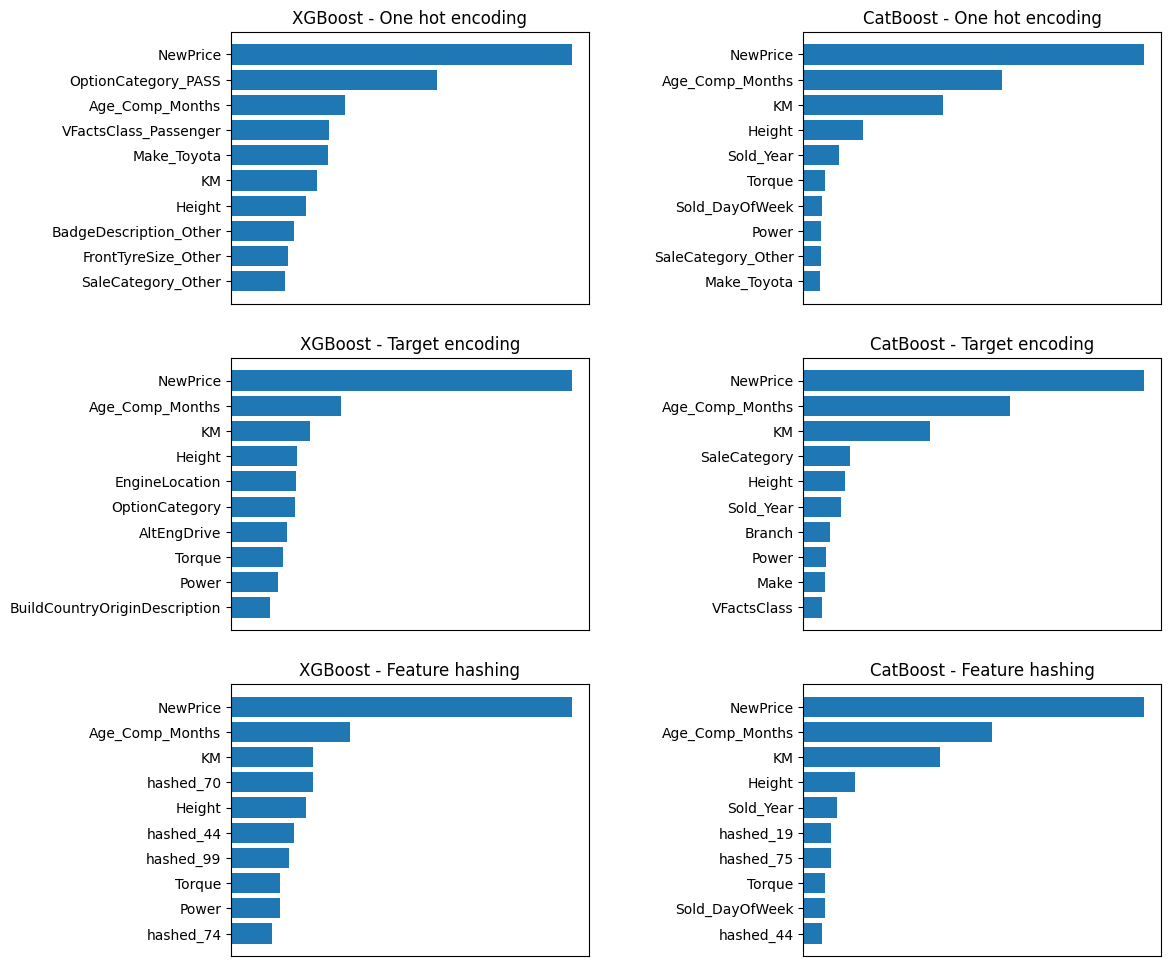

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import load

def plot_importance(ax, values, title, features_name, num_values_shown=10):
    sorted_idx = np.argsort(values)
    values_to_plot = np.array(values)[sorted_idx][-num_values_shown:]
    labels_to_plot = features_name[sorted_idx][-num_values_shown:]

    ax.barh(range(num_values_shown), values_to_plot)
    ax.set_xticks([])
    ax.set_yticks(range(num_values_shown))
    ax.set_yticklabels(labels_to_plot)
    ax.set_title(title)

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
fig.subplots_adjust(wspace=0.6) 
# fig.tight_layout(pad=5.0)

for i, (save_dir, x_train, x_test) in enumerate([
    ('models/One_hot_encoding', X_train_OH_encoded, X_test_OH_encoded), 
    ('models/Target_encoding', X_train_T_encoded, X_test_T_encoded), 
    ('models/Feature_hashing', X_train_FH_encoded, X_test_FH_encoded)]):

    encoding_name = save_dir.split('/')[-1].replace('_', ' ')
    features_name = x_train.columns

    # XGBoost
    XGBoost_model = load(f'{save_dir}/XGBoost_best_model.pkl')
    xgb_importance = XGBoost_model.feature_importances_
    plot_importance(ax[i, 0], xgb_importance, f'XGBoost - {encoding_name}', features_name)

    # CatBoost
    CatBoost_model = load(f'{save_dir}/CatBoost_best_model.pkl')
    cat_importance = CatBoost_model.get_feature_importance()
    plot_importance(ax[i, 1], cat_importance, f'CatBoost - {encoding_name}', features_name)

plt.show()

## Inference pipeline that show how it handles new categorical data

In [36]:
def load_model_and_predict(model_name, X_input, model_dir="models"):
    model_path = f"{model_dir}/{model_name}_best_model.pkl"
    model = load(model_path)
    return model.predict(X_input)

# Sample input without 'Sold_Amount' column
sample_input = pd.read_csv('sample_input.csv')
sample_input['Make'] = "Porte" # Add a new 'Make' category

print("Sample input:", sample_input.shape)
sample_input

Sample input: (3, 129)


,Make,Model,MakeCode,FamilyCode,YearGroup,MonthGroup,SequenceNum,Description,CurrentRelease,ImportFlag,...,TradeMax,PrivateMax,NewPrice,Colour,Branch,SaleCategory,Sold_Date,Compliance_Date,Age_Comp_Months,KM
0,Porte,Falcon,FORD,FALCON,2005,0,1,BA Mk II XT Sedan 4dr Spts Auto 4sp 4.0i,F,L,...,NaN,4100.0,35555.0,Mercury Silver,Belmore (NSW),Fixed Price,2008-08-31 00:00:00.000,03/2005,41.0,60255.0
1,Porte,Ranger,FORD,RANGER,2013,0,27,PX XL Utility Double Cab 4dr Spts Auto 6sp 4x4...,F,L,...,25800.0,30600.0,48390.0,Silver,Belmore (NSW),Auction,2014-10-07 00:00:00.000,12/2013,10.0,53346.0
2,Porte,Tarago,TOYO,TARAGO,2007,0,0,ACR50R GLi Wagon 8st 5dr Spts Auto 4sp 2.4i,F,L,...,9700.0,12400.0,49490.0,Silver,Hobart (TAS),Special Fixed Price,2009-05-23 00:00:00.000,01/2007,28.0,44355.0


In [37]:
# Encoding and models list
encodings = ['Target_encoding', 'Feature_hashing', 'One_hot_encoding']
models = ['HistGradientBoosting', 'CatBoost', 'XGBoost']

results = []
for encoding in encodings:
    # Load the encoding pipeline and transform the sample input
    encoding_pipeline = load(f'{INFERENCE_PIPELINE_PATH}/{encoding}_InferencePipeline.pkl')
    sample_input_encoded = encoding_pipeline.transform(sample_input)

    # Iterate through models and make predictions
    for model_name in models:
        # Predict with the current model
        y_pred = load_model_and_predict(model_name, sample_input_encoded, model_dir=f'models/{encoding}')
        y_pred = np.round(y_pred, 2)

        # Store the result in the DataFrame
        result = {'Encoding': encoding, 'Model': model_name,'Prediction': y_pred}
        results.append(result)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
results_df

,Encoding,Model,Prediction
0,Target_encoding,HistGradientBoosting,"[12840.85, 36109.75, 31008.18]"
1,Target_encoding,CatBoost,"[11912.09, 33003.21, 29943.43]"
2,Target_encoding,XGBoost,"[18020.0, 36216.24, 35613.74]"
3,Feature_hashing,HistGradientBoosting,"[11335.03, 33675.87, 29533.56]"
4,Feature_hashing,CatBoost,"[11311.26, 34977.78, 31034.39]"
5,Feature_hashing,XGBoost,"[11715.9, 34429.23, 30849.5]"
6,One_hot_encoding,HistGradientBoosting,"[12408.39, 34227.44, 29452.41]"
7,One_hot_encoding,CatBoost,"[11471.37, 34228.94, 29208.28]"
8,One_hot_encoding,XGBoost,"[11278.22, 33596.58, 30602.26]"
